<a href="https://colab.research.google.com/github/Timothy88996/Tugas_Kelompok_Labeling_Data_dan_Klasifikasi/blob/main/google_colab_code/Final_PTT_Classi_CK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path

In [64]:
path_data = '/content/drive/MyDrive/Pemrosesan Teks Teori/twitter_crawling_files/bbm_etanol_2label.csv'
path_save = '/content/drive/MyDrive/Pemrosesan Teks Teori/twitter_crawling_files/bbm_etanol_label_by_model.csv'

#Library

In [65]:
!pip install nltk
!pip install Sastrawi
!pip install prettytable
!pip install graphviz

In [66]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# IMPORT LIBRARY
from graphviz import Source
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# G-DRIVE

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Read Data

In [68]:
df = pd.read_csv(path_data)
df.sample(6)

,full_text,label
184,@jek___ Makasih infonya sangat bermanfaat bagi...,Positif
24,@p4piKRiS @sharpandshark Emank iya.. Lah wong ...,Negatif
210,@udanudinudan @WagimanDeep212_ BBM Bobibos ada...,Positif
298,Tahukah kamu? Mulai tahun 2026 bahan bakar di ...,Positif
70,be bahlil &gt;saingan pertamina pada di singki...,Negatif
44,@Telkomsel Woy komitmen kalian itu cuman lip s...,Negatif


In [69]:
def info(df):
  a = len(df)
  return f"Dataset memiliki '{a}' data."

def count_feat(df, a, b):
  c = df[df[a] == b]
  d = len(c)
  return f"Terdapat '{d}' data '{b}', pada kolom '{a}'"

In [70]:
a = info(df)
print(a)

Dataset memiliki '300' data.


In [71]:
Positive = count_feat(df, 'label', 'Positif')
Negative = count_feat(df, 'label', 'Negatif')

print(Positive)
print(Negative)

Terdapat '120' data 'Positif', pada kolom 'label'
Terdapat '180' data 'Negatif', pada kolom 'label'


#Preprocessing

In [72]:
additions = ['sih', 'nih', 'kok', 'lah', 'moga',
             'nya', 'tuh', 'dah', 'amp', 'teru',
             'utk', 'kan', 'tau', 'si', 'royo',
             'kali', 'deh', 'kek', 'yah', 'dong',
             'gt', 'kdm', 'pas', 'jg', 'lg', 'sana',
             'mah', 'jadi', 'mana', 'ambah', 'bahlil',
             'lahadalia', 'jd', 'cuma', 'lalu', 'e', 'ron',
             'bp', 'biar', 'gin', 'lalu', 'terus', 'bahlul']


# === Kamus Normalisasi (kata tidak baku → baku) ===
normalisasi_kamus = {
    'gk': 'tidak', 'ga': 'tidak', 'nggak': 'tidak', 'tdk': 'tidak', 'g': 'tidak',
    'jgn': 'jangan', 'dr': 'dari', 'yg': 'yang', 'dgn': 'dengan', 'aja': 'saja',
    'blm': 'belum', 'udh': 'sudah', 'klo': 'kalau', 'kalo': 'kalau',
    'skrg': 'sekarang', 'sm': 'sama', 'tp': 'tapi', 'trs': 'terus', 'bgt': 'banget',
    'dg': 'dengan', 'krn': 'karena', 'sy': 'aku', 'gw': 'aku',
    'gue': 'aku', 'ak': 'aku', 'ku': 'aku', 'loe': 'kamu',
    'lu': 'kamu', 'km': 'kamu', 'lo': 'kamu', 'liat': 'lihat',
    'moga': 'semoga', 'tuju': 'menuju',
    'tuhlah': 'dia', 'mas': 'kak', 'mba': 'kak', 'tsb': 'tersebut', 'sdh': 'sudah'
}

# Non baku to baku
factory_stem = StemmerFactory()
stemmer = factory_stem.create_stemmer()

# Delete sambung
factory_stop = StopWordRemoverFactory()
stopwords_ind = set(factory_stop.get_stop_words())
stopwords_ind.update(additions)

In [73]:
# === Fungsi pembersihan teks ===
def bersihkan_teks(teks):
    teks = str(teks).lower() # Case Folding
    teks = re.sub(r"http\S+", "", teks)          # hapus URL
    teks = re.sub(r"@[A-Za-z0-9_]+", "", teks)   # hapus mention
    teks = re.sub(r"#[A-Za-z0-9_]+", "", teks)   # hapus hashtag
    teks = re.sub(r"[^a-zA-Z\s]", " ", teks)     # hapus angka & simbol
    teks = re.sub(r"\s+", " ", teks)             # hapus spasi berlebih
    return teks.strip()

# === Normalisasi kata tidak baku & Tokenizing ===
def normalisasi_kata(teks):
    tokens = nltk.word_tokenize(teks) # Tokenisasi
    hasil = []
    for k in tokens:
        if k in normalisasi_kamus:
            hasil.append(normalisasi_kamus[k])
        else:
            hasil.append(k)
    return hasil  # hasil list

# === Stopword Removal ===
def hapus_stopwords(tokens):
    return [t for t in tokens if t not in stopwords_ind]

# === Lematisasi / Stemming menggunakan Sastrawi ===
def stemming_list(tokens):
    return [stemmer.stem(k) for k in tokens]

# === Pipeline Lengkap Pengolahan Teks ===
def proses_teks(teks):
    teks_bersih = bersihkan_teks(teks)
    tokens_norm = normalisasi_kata(teks_bersih)
    tokens_no_stop = hapus_stopwords(tokens_norm)
    tokens_stem = stemming_list(tokens_no_stop)
    return " ".join(tokens_stem) # Token to Not Token

In [74]:
# === Jalankan Pipeline ===
df['cleaned'] = df['full_text'].apply(proses_teks)
df = df[['cleaned', 'label']]
df.sample(7)

,cleaned,label
46,berita banyak motor mbrebet gara bbm pake etanol,Negatif
200,semua bioetanol waktu masuk kemarin marah soal...,Positif
172,nama pertamina mau permak kayak apa makin jomb...,Negatif
74,pertamina buka bengkel gratis motor brebet luc...,Negatif
214,bijak campur etanol bbm sebut potensi tingkat ...,Positif
59,pak menteri erti visi bapak gera masyarakat ta...,Negatif
155,kendara rusak kena bbm etanol esdm bodo jalan ...,Negatif


#WordCloud (jgn dimasukin ke laporan)

In [75]:
# === Visualisasi WordCloud ===
text_all = " ".join(df['cleaned'])
wordcloud = WordCloud(width=800, height=600, background_color='white',
                      collocations=False).generate(text_all)

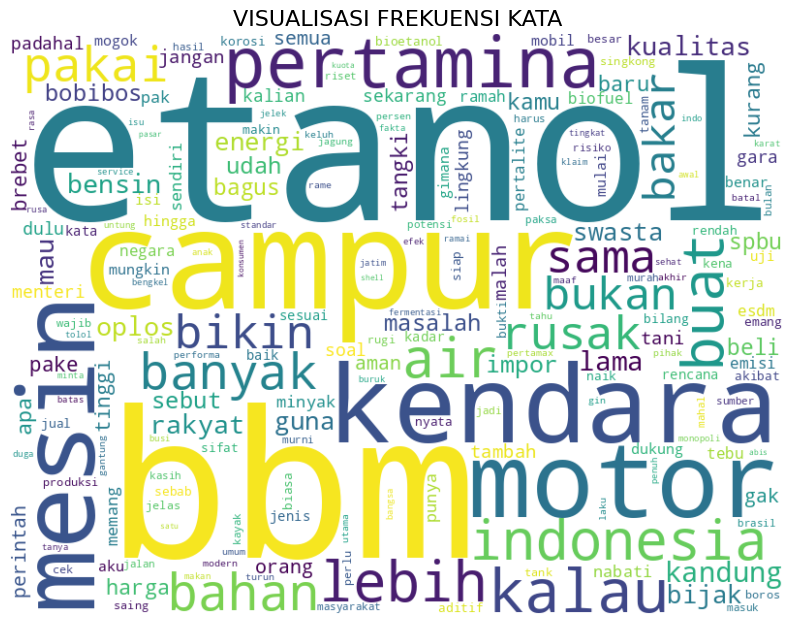

In [76]:
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("VISUALISASI FREKUENSI KATA", fontsize=16)
plt.show()

#Modelling

In [77]:
def xys(text, label, split):
  X_train, X_test, y_train, y_test = train_test_split(text, label, test_size=split, random_state=42, stratify=label)
  return X_train, X_test, y_train, y_test

def tfidf(X_train, X_test, tfidf):
  a = tfidf.fit_transform(X_train)
  b = tfidf.transform(X_test)
  return a, b

def distribute(X_Train, X_Test, y_Train, y_Test, amt):
  a = len(X_Train)
  b = len(X_Test)
  c = y_Train.value_counts()
  d = y_Test.value_counts()
  e = X_Train.head(amt)
  f = X_Test.head(amt)
  g = f"Data 'X_train' memiliki {a} data dengan contoh:\n{e}\n"
  h = f"Data 'X_test' memiliki {b} data dengan contoh:\n{f}\n"
  i = f"Data 'y_train' memiliki distribusi sebesar = \n{c}\n"
  j = f"Data 'y_test' memiliki distribusi sebesar = \n{d}\n"

  return g, h, i, j

In [78]:
X_Train, X_Test, y_Train, y_Test = xys(df['cleaned'], df['label'], 0.25)

In [79]:
w, a, s, d = distribute(X_Train, X_Test, y_Train, y_Test, 5)
print(w)
print(a)
print(s)
print(d)

Data 'X_train' memiliki 225 data dengan contoh:
225    bbm pertamina pakai etanol hujat bobibos salah...
112    ni perintah maksa banget bikin etanol padahal ...
100    bijak negara sering bikin susah rakyat lahir e...
44     woy komitmen kalian cuman lip service negara o...
73     ajak turing naik motor trus isi bbm bareng cam...
Name: cleaned, dtype: object

Data 'X_test' memiliki 75 data dengan contoh:
14     pertamina pgen pegang kendali monopoli import ...
72              henti bbm campur etanol rakyat kasi enak
89     darimana ide bbm campur etanol saing spbu swas...
131    kalau periksa sesuaindg tentu arti campur bbm ...
8      mahasiswa kalsel protes masalah motor brebet d...
Name: cleaned, dtype: object

Data 'y_train' memiliki distribusi sebesar = 
label
Negatif    135
Positif     90
Name: count, dtype: int64

Data 'y_test' memiliki distribusi sebesar = 
label
Negatif    45
Positif    30
Name: count, dtype: int64



In [80]:
tfidfv = TfidfVectorizer(max_features=800, min_df=3, max_df=0.6, ngram_range=(1, 1))
X_Train, X_Test = tfidf(X_Train, X_Test, tfidfv)

In [81]:
dt_model = DecisionTreeClassifier(random_state=42, min_samples_split=30, max_depth=14, criterion='entropy')
dt_model.fit(X_Train, y_Train)

DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_split=30,
                       random_state=42)

In [82]:
y_pred_test = dt_model.predict(X_Test)
y_pred_train = dt_model.predict(X_Train)

a = accuracy_score(y_Train, y_pred_train)
b = accuracy_score(y_Test, y_pred_test)

print("\n=== HASIL EVALUASI MODEL ===")
print("Akurasi (Training):", accuracy_score(y_Train, y_pred_train))
print("Akurasi (Testing):", accuracy_score(y_Test, y_pred_test))
print("\nConfusion Matrix (Testing):\n", confusion_matrix(y_Test, y_pred_test))
print("\nClassification Report (Testing):\n", classification_report(y_Test, y_pred_test, digits=4))

# cek overfit
c = a - b
print("\nSelisih Akurasi Latih dan Uji")
if c >= 0.10:
  print(f"Terdapat Overfit : \n{c}")
else:
  print(f"Tidak Terdapat Overfit : \n{c}")


=== HASIL EVALUASI MODEL ===
Akurasi (Training): 0.7955555555555556
Akurasi (Testing): 0.7066666666666667

Confusion Matrix (Testing):
 [[45  0]
 [22  8]]

Classification Report (Testing):
               precision    recall  f1-score   support

     Negatif     0.6716    1.0000    0.8036        45
     Positif     1.0000    0.2667    0.4211        30

    accuracy                         0.7067        75
   macro avg     0.8358    0.6333    0.6123        75
weighted avg     0.8030    0.7067    0.6506        75


Selisih Akurasi Latih dan Uji
Tidak Terdapat Overfit : 
0.0888888888888889


#Pttable

In [83]:
from prettytable import PrettyTable

# PREDIKSI UNTUK SELURUH DATA
tfidf_all = tfidfv.transform(df['cleaned'])
df['label_libr'] = dt_model.predict(tfidf_all)

# TAMBAHKAN KOLOM STATUS
df['status'] = df.apply(lambda x: "Benar" if x['label'] == x['label_libr'] else "Salah", axis=1)

# PRETTY TABLE
table = PrettyTable()
table.field_names = ["full_text", "label", "label_libr", "status"]

def potong(teks, panjang=60):
    return teks[:panjang] + "..." if len(teks) > panjang else teks

for i in range(len(df)):
    table.add_row([
        potong(df['cleaned'].iloc[i]),
        df['label'].iloc[i],
        df['label_libr'].iloc[i],
        df['status'].iloc[i]
    ])

# AUTO-DETECT LABEL COUNT
# hitung jumlah setiap kelas original
ori_counts = df['label'].value_counts()

# hitung jumlah setiap kelas model
model_counts = df['label_libr'].value_counts()

# ambil nama label (kelas) secara otomatis
ori_labels = ori_counts.index.tolist()
model_labels = model_counts.index.tolist()

print("\n=========== STATISTIK DATA ===========")
print(f"Total data                     : {len(df)}")
print(f"Label prediksi BENAR           : {(df['status']=='Benar').sum()}")
print(f"Label prediksi SALAH           : {(df['status']=='Salah').sum()}")

print("\n--- ORIGINAL LABEL ---")
for lbl in ori_labels:
    print(f"Jumlah label '{lbl}' (original) : {ori_counts[lbl]}")

print("\n--- MODEL LABEL ---")
for lbl in model_labels:
    print(f"Jumlah label '{lbl}' (model)    : {model_counts[lbl]}")

print("======================================")

print("\n",table)



=========== STATISTIK DATA ===========
Total data                     : 300
Label prediksi BENAR           : 232
Label prediksi SALAH           : 68

--- ORIGINAL LABEL ---
Jumlah label 'Negatif' (original) : 180
Jumlah label 'Positif' (original) : 120

--- MODEL LABEL ---
Jumlah label 'Negatif' (model)    : 242
Jumlah label 'Positif' (model)    : 58

 +-----------------------------------------------------------------+---------+------------+--------+
|                            full_text                            |  label  | label_libr | status |
+-----------------------------------------------------------------+---------+------------+--------+
| kemaren ribut bbm tambah etanol gilir bobibos puja abis an k... | Negatif |  Negatif   | Benar  |
| bbm nabati etanol gak mungkin guna murni bbm nabati guna mur... | Negatif |  Negatif   | Benar  |
| pak sjafrie ajak perlu sibuk etanol hapus subsidi bbm buat s... | Negatif |  Negatif   | Benar  |
| mau pakai bobibos etanol apa penting gantu

In [84]:
# KETERANGAN TAMBAHAN
# pastikan hanya 2 kelas di label asli
ori_labels = df['label'].value_counts().index.tolist()
model_labels = df['label_libr'].value_counts().index.tolist()

# deteksi positif/negatif
pos_label = "Positif"
neg_label = "Negatif"

# Label positif tapi prediksi negatif
label_pos_to_neg = ((df['label'] == pos_label) & (df['label_libr'] == neg_label)).sum()

# Label positif dan prediksi positif
label_pos_to_pos = ((df['label'] == pos_label) & (df['label_libr'] == pos_label)).sum()

# Prediksi positif tapi label negatif
libr_pos_to_neg = ((df['label_libr'] == pos_label) & (df['label'] == neg_label)).sum()

# Prediksi negatif dan label negatif
libr_neg_to_neg = ((df['label_libr'] == neg_label) & (df['label'] == neg_label)).sum()


print("\n=========== KETERANGAN TAMBAHAN ===========")
print(f"Label POSITIF → prediksi NEGATIF : {label_pos_to_neg}")
print(f"Label POSITIF → prediksi POSITIF : {label_pos_to_pos}")
print(f"Prediksi POSITIF → label NEGATIF : {libr_pos_to_neg}")
print(f"Prediksi NEGATIF → label NEGATIF : {libr_neg_to_neg}")
print("============================================")



=========== KETERANGAN TAMBAHAN ===========
Label POSITIF → prediksi NEGATIF : 65
Label POSITIF → prediksi POSITIF : 55
Prediksi POSITIF → label NEGATIF : 3
Prediksi NEGATIF → label NEGATIF : 177


In [85]:
df.to_csv(path_save, index=False)
print(f"DataFrame with 'label_libr' and 'status' columns saved to : \n{path_save}")

DataFrame with 'label_libr' and 'status' columns saved to : 
/content/drive/MyDrive/Pemrosesan Teks Teori/twitter_crawling_files/bbm_etanol_label_by_model.csv


#Graph

In [86]:
feature_names = tfidfv.get_feature_names_out()
class_names = ['Negatif', 'Positif']

dot_data = export_graphviz(
    dt_model,
    out_file=None,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    special_characters=True,

    # tambahan:
    max_depth=4,
    impurity=True,
    proportion=True,
    precision=2,
    node_ids=True,
    leaves_parallel=True,
)

# Insert the size attribute into the dot_data string
dot_data = dot_data.replace('digraph Tree {', 'digraph Tree {\n    graph [size="10,8!"];', 1)

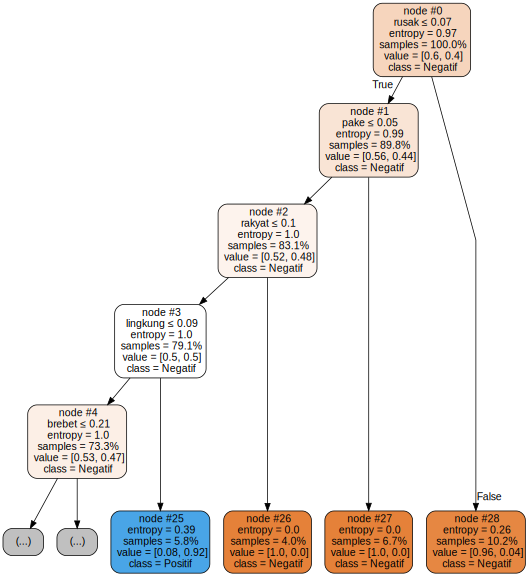

In [87]:
graph = Source(dot_data, format='png')
graph.pipe()
graph

#Cohens Kappa

In [88]:
# LOAD DATASETS
df = pd.read_csv(path_save)

# Tampilkan 5 sample data
print("===== Sample Data =====")
display(df.head())

===== Sample Data =====


,cleaned,label,label_libr,status
0,kemaren ribut bbm tambah etanol gilir bobibos ...,Negatif,Negatif,Benar
1,bbm nabati etanol gak mungkin guna murni bbm n...,Negatif,Negatif,Benar
2,pak sjafrie ajak perlu sibuk etanol hapus subs...,Negatif,Negatif,Benar
3,mau pakai bobibos etanol apa penting gantung s...,Negatif,Negatif,Benar
4,bbm murni campur etanol mending isi bbm spbu s...,Negatif,Positif,Salah


In [89]:
# DATA CLEANING WAJIB
# agar manual dan sklearn sama
df['label'] = df['label'].astype(str).str.strip().str.lower()
df['label_libr'] = df['label_libr'].astype(str).str.strip().str.lower()

# drop baris yang hilang nilai label
df = df.dropna(subset=['label','label_libr'])

# SET LABEL URUTAN TETAP
# urutan dicocokkan ke model
labels = ["positif", "negatif"]

# EXTRACT LABEL
y_true = df['label']
y_pred = df['label_libr']

In [90]:
# CONFUSION MATRIX DENGAN LABEL FIX
cm = confusion_matrix(y_true, y_pred, labels=labels)

print("===== Confusion Matrix =====")
print(pd.DataFrame(cm,
                   index=["True Positif","True Negatif"],
                   columns=["Pred Positif","Pred Negatif"]))

===== Confusion Matrix =====
              Pred Positif  Pred Negatif
True Positif            55            65
True Negatif             3           177


In [91]:
# HITUNG MANUAL KAPPA
# ambil nilai
TP = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TN = cm[1,1]

# Hitung total
N = cm.sum()

# Observed Agreement
P_o = (TP + TN) / N

# Expected Agreement
true_pos = (TP + FN) / N
true_neg = (FP + TN) / N
pred_pos = (TP + FP) / N
pred_neg = (FN + TN) / N

P_e = (true_pos * pred_pos) + (true_neg * pred_neg)

# Final Kappa Manual
kappa_manual = (P_o - P_e) / (1 - P_e)

print("===== Hasil Manual =====")
print("Observed Agreement (P_o):", round(P_o,4))
print("Expected Agreement (P_e):", round(P_e,4))
print("Cohen's Kappa (Manual):", round(kappa_manual,4))

===== Hasil Manual =====
Observed Agreement (P_o): 0.7733
Expected Agreement (P_e): 0.5613
Cohen's Kappa (Manual): 0.4833


In [92]:
# VALIDASI SKLEARN
kappa_sklearn = cohen_kappa_score(y_true, y_pred, labels=labels)

print("===== Sklearn =====")
print("Cohen's Kappa (Sklearn):", round(kappa_sklearn,4))

===== Sklearn =====
Cohen's Kappa (Sklearn): 0.4833
